In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_curve, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
import seaborn as sns

# Предобработка

In [2]:
df = pd.read_csv('our_project.csv')
df['Neighborhood'] = df['Neighborhood'].str.replace(' ', '').str.replace('-', '') #убрали пробелы и др. символы, чтоб ниче потом не мешало
print(df.shape)
df.head(10)

(5000, 10)


,Price_Total,Area,Price_Meter,Rooms,Floor_Live,Floor_Total,Zone,Neighborhood,Distance,Time
0,11850601,36.5,324674,1,24,38,ЮВАО,Южнопортовыйрайон,5.0,9.0
1,9265190,34.2,270912,1,15,33,ВАО,Метрогородок,10.5,12.0
2,10594407,34.2,309778,2,7,15,СВАО,Бабушкинскийрайон,12.0,11.0
3,9353943,36.1,259112,1,31,33,ЮАО,ЧертановоЮжное,18.5,7.0
4,8484026,24.4,347706,0,19,21,ЗАО,ОчаковоМатвеевское,12.1,9.0
5,8296707,34.2,242452,1,13,33,ЮАО,ЧертановоЮжное,18.5,7.0
6,9783011,42.6,229810,1,23,33,ЮАО,ЧертановоЮжное,18.5,7.0
7,9138416,35.9,254552,2,19,33,СВАО,Отрадное,10.9,19.0
8,13086430,42.5,307916,1,32,38,ЮВАО,Южнопортовыйрайон,5.0,9.0
9,9205334,35.9,256416,1,11,28,ВАО,Гольяново,9.8,11.0


In [3]:
print(df['Zone'].unique())
print(df['Neighborhood'].unique())

#https://habr.com/ru/articles/666234/ - отсюда взят алгоритма для всех категориальных данных к числовым.

encoder = OneHotEncoder()
categorical_features = df[['Zone', 'Neighborhood']]
encoded_features = encoder.fit_transform(categorical_features)
df = df.join(pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names(['Zone', 'Neighborhood'])))

['ЮВАО' 'ВАО' 'СВАО' 'ЮАО' 'ЗАО' 'САО' 'Новая Москва' 'ЮЗАО' 'СЗАО']
['Южнопортовыйрайон' 'Метрогородок' 'Бабушкинскийрайон' 'ЧертановоЮжное'
 'ОчаковоМатвеевское' 'Отрадное' 'Гольяново' 'Молжаниновскийрайон'
 'Московский' 'ФилёвскийПарк' 'НагатиноСадовники' 'Черёмушки'
 'Рязанскийрайон' 'ПокровскоеСтрешнево']


**Здесь мы избавились от текстовых признаков, воспользовавшиься one-hot-encoding. Удалили пробелы, спец.символы в некоторых колонках, т.к. они в дальнейшем помешали бы**

In [4]:
df.columns

Index(['Price_Total', 'Area', 'Price_Meter', 'Rooms', 'Floor_Live',
       'Floor_Total', 'Zone', 'Neighborhood', 'Distance', 'Time', 'Zone_ВАО',
       'Zone_ЗАО', 'Zone_Новая Москва', 'Zone_САО', 'Zone_СВАО', 'Zone_СЗАО',
       'Zone_ЮАО', 'Zone_ЮВАО', 'Zone_ЮЗАО', 'Neighborhood_Бабушкинскийрайон',
       'Neighborhood_Гольяново', 'Neighborhood_Метрогородок',
       'Neighborhood_Молжаниновскийрайон', 'Neighborhood_Московский',
       'Neighborhood_НагатиноСадовники', 'Neighborhood_Отрадное',
       'Neighborhood_ОчаковоМатвеевское', 'Neighborhood_ПокровскоеСтрешнево',
       'Neighborhood_Рязанскийрайон', 'Neighborhood_ФилёвскийПарк',
       'Neighborhood_ЧертановоЮжное', 'Neighborhood_Черёмушки',
       'Neighborhood_Южнопортовыйрайон'],
      dtype='object')

# EDA

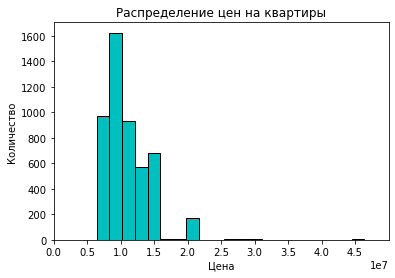

In [5]:
plt.hist(df['Price_Total'], bins=50, color = 'c', edgecolor='black')
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.xlim(0, 50000000)
plt.xticks(range(0, 50000000, 5000000))
plt.show()

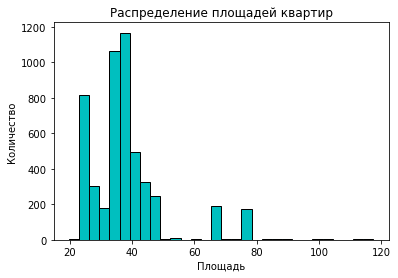

In [6]:
plt.hist(df['Area'], bins=30, color = 'c', edgecolor='black')
plt.title('Распределение площадей квартир')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

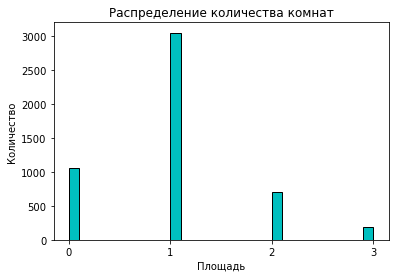

3


In [7]:
plt.hist(df['Rooms'], bins=30, color = 'c', edgecolor='black')
plt.title('Распределение количества комнат')
plt.xticks(np.arange(0, 4, 1))
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()
print(max(df['Rooms']))

**Пояснение:** 0 комнат означает квартиру-студию.

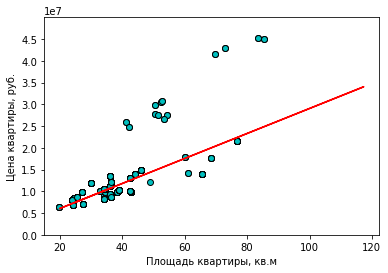

[287269.47710673 322007.03637237]
299168.3336


In [8]:
plt.scatter(df['Area'], df['Price_Total'], color = 'c', edgecolor='black')

fit = np.polyfit(df['Area'], df['Price_Total'], 1)
plt.plot(df['Area'], fit[0] * df['Area'] + fit[1], color='red')

plt.xlabel('Площадь квартиры, кв.м')
plt.ylim(0, 50000000)
plt.yticks(range(0, 50000000, 5000000))
plt.ylabel('Цена квартиры, руб.')
plt.show()

print(fit)
print(df['Price_Meter'].mean())

**Соотношение площади квартиры с ее ценой. Построение полиномиальной регрессии.**

<AxesSubplot:xlabel='Floor_Total', ylabel='Rooms'>

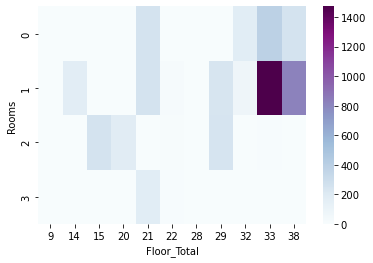

In [9]:
cross_tab = pd.crosstab(df['Rooms'], df['Floor_Total'])
sns.heatmap(cross_tab, cmap='BuPu')

**Наиболее популярное сочетание: 1 комнатная квартира в 33-38 этажном доме.**

In [10]:
correlations = df[['Zone_ВАО', 'Zone_ЗАО', 'Zone_Новая Москва', 'Zone_САО', 'Zone_СВАО', 'Zone_СЗАО',
       'Zone_ЮАО', 'Zone_ЮВАО', 'Zone_ЮЗАО', 'Price_Meter']].corr()
correlations['Price_Meter']

Zone_ВАО            -0.015962
Zone_ЗАО             0.354608
Zone_Новая Москва   -0.024451
Zone_САО            -0.140486
Zone_СВАО           -0.006571
Zone_СЗАО            0.480714
Zone_ЮАО            -0.649064
Zone_ЮВАО            0.143578
Zone_ЮЗАО            0.277665
Price_Meter          1.000000
Name: Price_Meter, dtype: float64

**Здесь мы видим, что статистически благоприятно влияет на цену квартиры ее расположение, например, в Северо-Западном, Юго-Западном, Западном Автономных Округах. Противоположная ситуация, например, в Южном, Восточном Автомных Округах.**

In [11]:
correlations = df[['Neighborhood_Бабушкинскийрайон',
       'Neighborhood_Гольяново', 'Neighborhood_Метрогородок',
       'Neighborhood_Молжаниновскийрайон', 'Neighborhood_Московский',
       'Neighborhood_НагатиноСадовники', 'Neighborhood_Отрадное',
       'Neighborhood_ОчаковоМатвеевское', 'Neighborhood_ПокровскоеСтрешнево',
       'Neighborhood_Рязанскийрайон', 'Neighborhood_ФилёвскийПарк',
       'Neighborhood_ЧертановоЮжное', 'Neighborhood_Черёмушки',
       'Neighborhood_Южнопортовыйрайон', 'Price_Meter']].corr()
correlations['Price_Meter']

Neighborhood_Бабушкинскийрайон      0.044912
Neighborhood_Гольяново             -0.004190
Neighborhood_Метрогородок          -0.016869
Neighborhood_Молжаниновскийрайон   -0.140486
Neighborhood_Московский            -0.024451
Neighborhood_НагатиноСадовники      0.054195
Neighborhood_Отрадное              -0.095990
Neighborhood_ОчаковоМатвеевское     0.153059
Neighborhood_ПокровскоеСтрешнево    0.480714
Neighborhood_Рязанскийрайон        -0.119507
Neighborhood_ФилёвскийПарк          0.390619
Neighborhood_ЧертановоЮжное        -0.687448
Neighborhood_Черёмушки              0.277665
Neighborhood_Южнопортовыйрайон      0.241993
Price_Meter                         1.000000
Name: Price_Meter, dtype: float64

**Здесь аналогично мы видим, что статистически благоприятно влияет на цену квартиры ее расположение, например, в Покровское-Стрешнево, Филёвский парк, Черёмушки районах Москвы. Противоположная ситуация, например, в районе Чертаново Южное.**

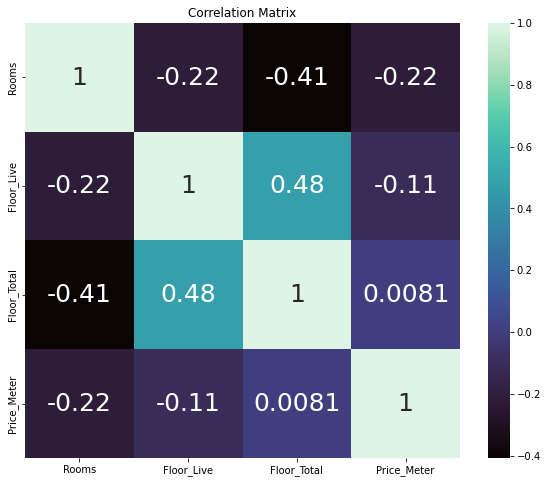

In [12]:
correlations = df[['Rooms', 'Floor_Live', 'Floor_Total', 'Price_Meter']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='mako', square=True, annot_kws={"fontsize": 25})
plt.title('Correlation Matrix')
plt.show()

**Здесь мы видим, что количество комнат и этаж негативно влияет на цену за квадратный ментр, общее количество этажей в доме почти не оказывает никакого влияния. Кроме того, также можно заметить, чем больше этажей в доме, тем меньше комнат в квартире.**

# Проверка гипотез

**Гипотеза**: Округ и район влияет на цену за квадратный метр

**Метод**: ANOVA (предложен Chat GPT, его комментарий ниже:)

**INPUT**: Как работает модель Anova, как интерпретировать ее результаты? Для исследования каких зависимостей она хороша?

**CHAT-GPT**: Модель ANOVA (анализ дисперсии) используется для определения статистической значимости различий между средними значениями двух или более групп или условий. Она позволяет оценить влияние факторов на зависимую переменную и определить, есть ли статистически значимые различия между этими факторами.

Результаты модели ANOVA представлены в таблице ANOVA, которая содержит степени свободы, суммы квадратов, среднеквадратические отклонения, значения статистики F и p-значения для каждого фактора и ошибки модели.

Интерпретация результатов модели ANOVA включает следующие шаги:

Проверка гипотезы: Нулевая гипотеза предполагает, что нет статистически значимых различий между группами или условиями. Альтернативная гипотеза предполагает, что существуют статистически значимые различия.

Значение статистики F: Значение статистики F вычисляется как отношение среднеквадратического отклонения между группами к среднеквадратическому отклонению внутри групп. Большое значение статистики F указывает на наличие статистически значимых различий между группами.

P-значение: P-значение представляет вероятность получить наблюдаемое значение статистики F или еще более экстремальное значение, при условии, что нулевая гипотеза верна. Если p-значение меньше выбранного уровня значимости (обычно 0.05), то нулевая гипотеза отвергается, и можно сделать вывод о статистически значимых различиях между группами.

Выводы: Если нулевая гипотеза отвергается, можно сделать вывод о статистически значимых различиях между группами или условиями. Если нулевая гипотеза не отвергается, можно сделать вывод, что различия между группами статистически незначимы.

Модель ANOVA хорошо подходит для исследования зависимостей, когда есть несколько групп или условий, и требуется определить, есть ли статистически значимые различия между этими группами. Например, она может использоваться для определения влияния разных лекарственных препаратов на эффективность лечения, влияния разных методов обучения на успеваемость студентов или влияния различных рекламных кампаний на продажи товаров.

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Price_Meter ~ Zone_ВАО + Zone_ЗАО + Zone_САО + Zone_СВАО + Zone_СЗАО + Zone_ЮАО + Zone_ЮВАО + Zone_ЮЗАО'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# Вывод результатов ANOVA
if anova_table['PR(>F)'][0] < 0.05:
    print("Отвергаем нулевую гипотезу. Округ влияет на цену за квадратный метр.")
else:
    print('Не отвергаем нулевую гипотезу. Нет статистически значимого влияния района на цену')

C:\Users\a7987\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\a7987\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


                 sum_sq      df           F        PR(>F)
Zone_ВАО   4.895974e+09     1.0    6.148767  1.318313e-02
Zone_ЗАО   2.247879e+10     1.0   28.230722  1.123627e-07
Zone_САО   1.315468e+09     1.0    1.652073  1.987367e-01
Zone_СВАО  8.295568e+09     1.0   10.418258  1.255822e-03
Zone_СЗАО  2.398448e+11     1.0  301.216861  1.455942e-65
Zone_ЮАО   3.644711e+08     1.0    0.457733  4.987168e-01
Zone_ЮВАО  1.209634e+10     1.0   15.191582  9.840881e-05
Zone_ЮЗАО  2.484403e+10     1.0   31.201179  2.449524e-08
Residual   3.974098e+12  4991.0         NaN           NaN
Отвергаем нулевую гипотезу. Округ влияет на цену за квадратный метр.


In [35]:
import patsy
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'Price_Meter ~ Neighborhood_Бабушкинскийрайон + Neighborhood_Гольяново + Neighborhood_Метрогородок + Neighborhood_Молжаниновскийрайон + Neighborhood_Московский + Neighborhood_НагатиноСадовники + Neighborhood_Отрадное + Neighborhood_ОчаковоМатвеевское + Neighborhood_ПокровскоеСтрешнево + Neighborhood_Рязанскийрайон + Neighborhood_ФилёвскийПарк + Neighborhood_ЧертановоЮжное + Neighborhood_Черёмушки + Neighborhood_Южнопортовыйрайон'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# Вывод результатов ANOVA
if anova_table['PR(>F)'][0] < 0.05:
    print("Отвергаем нулевую гипотезу. Район влияет на цену за квадратный метр.")
else:
    print('Не отвергаем нулевую гипотезу. Нет статистически значимого влияния района на цену')

                                        sum_sq      df         F    PR(>F)
Neighborhood_Бабушкинскийрайон    1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Гольяново            1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Метрогородок         1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Молжаниновскийрайон  1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Московский           1.754928e+09     1.0  5.628959  0.017704
Neighborhood_НагатиноСадовники    1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Отрадное             1.754928e+09     1.0  5.628959  0.017704
Neighborhood_ОчаковоМатвеевское   1.754928e+09     1.0  5.628959  0.017704
Neighborhood_ПокровскоеСтрешнево  1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Рязанскийрайон       1.754928e+09     1.0  5.628959  0.017704
Neighborhood_ФилёвскийПарк        1.754928e+09     1.0  5.628959  0.017704
Neighborhood_ЧертановоЮжное       1.754928e+09     1.0  5.628959  0.017704
Neighborhood_Черёмушки   

# Машинное обучение

In [17]:
data = df.drop(['Price_Meter', 'Neighborhood', 'Zone'], axis = 1)
features = data.drop('Price_Total', axis=1)  # Все столбцы, кроме "Цена"
target = data['Price_Total']

In [18]:
data

,Price_Total,Area,Rooms,Floor_Live,Floor_Total,Distance,Time,Zone_ВАО,Zone_ЗАО,Zone_Новая Москва,...,Neighborhood_Московский,Neighborhood_НагатиноСадовники,Neighborhood_Отрадное,Neighborhood_ОчаковоМатвеевское,Neighborhood_ПокровскоеСтрешнево,Neighborhood_Рязанскийрайон,Neighborhood_ФилёвскийПарк,Neighborhood_ЧертановоЮжное,Neighborhood_Черёмушки,Neighborhood_Южнопортовыйрайон
0,11850601,36.5,1,24,38,5.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9265190,34.2,1,15,33,10.5,12.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10594407,34.2,2,7,15,12.0,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9353943,36.1,1,31,33,18.5,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8484026,24.4,0,19,21,12.1,9.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,15009300,45.9,2,6,29,11.2,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4996,9764700,26.9,1,22,29,11.2,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4997,8793187,36.2,1,20,33,18.5,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4998,8226025,34.1,1,9,33,18.5,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model = LinearRegression()
param_grid = {'normalize': [True, False],
              'fit_intercept': [True, False]}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие гиперпараметры для LinearRegressor:", grid_search.best_params_)

Лучшие гиперпараметры для LinearRegressor: {'fit_intercept': True, 'normalize': False}


In [34]:
model = LinearRegression(**grid_search.best_params_)
model.fit(X_train_scaled, y_train)

train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)
print(f"Train R^2 score: {train_score:.2f}")
print(f"Test R^2 score: {test_score:.2f}")

Train R^2 score: 0.94
Test R^2 score: 0.89


**Здесь попробовали применить обычную линейную регрессию, получили вполне неплохие результаты. Теперь воспользуемся Catboost:**

In [39]:
param_grid = {'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.5], 'depth': [4, 6, 8]}

model = CatBoostRegressor(verbose=False)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)


print("Лучшие гиперпараметры для CatBoostRegressor:", grid_search.best_params_)

Лучшие гиперпараметры для CatBoostRegressor: {'depth': 6, 'iterations': 100, 'learning_rate': 0.5}


In [40]:
model = CatBoostRegressor(**grid_search.best_params_, verbose = False)
model.fit(X_train_scaled, y_train)

train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)
print(f"Train R^2 score: {train_score:.2f}")
print(f"Test R^2 score: {test_score:.2f}")

Train R^2 score: 1.00
Test R^2 score: 0.99


**Качество модели серьезно улучшилось, получили отличный результат.**

In [48]:
features.columns

Index(['Area', 'Rooms', 'Floor_Live', 'Floor_Total', 'Distance', 'Time',
       'Zone_ВАО', 'Zone_ЗАО', 'Zone_Новая Москва', 'Zone_САО', 'Zone_СВАО',
       'Zone_СЗАО', 'Zone_ЮАО', 'Zone_ЮВАО', 'Zone_ЮЗАО',
       'Neighborhood_Бабушкинскийрайон', 'Neighborhood_Гольяново',
       'Neighborhood_Метрогородок', 'Neighborhood_Молжаниновскийрайон',
       'Neighborhood_Московский', 'Neighborhood_НагатиноСадовники',
       'Neighborhood_Отрадное', 'Neighborhood_ОчаковоМатвеевское',
       'Neighborhood_ПокровскоеСтрешнево', 'Neighborhood_Рязанскийрайон',
       'Neighborhood_ФилёвскийПарк', 'Neighborhood_ЧертановоЮжное',
       'Neighborhood_Черёмушки', 'Neighborhood_Южнопортовыйрайон'],
      dtype='object')

Мне стало интересно, решил посмотреть реальный пример прогнозирования цены, взял совсем другой сайт - ЦИАН (данные для проекта парсил с сайта m2.ru, т.к. с ЦИАНа не получилось) . Взял квартиру из ЖК Символ (в котором хочу когда-нибудь приобрести жилье) и решил оценить, насколько близкую цену к цене объявления предскажет модель.

https://www.cian.ru/sale/flat/279992274/

Вот квартира, параметры: 58 этаж, 2 комнаты, 14 этаж, 28 этажей в доме, 5 км до центра, 15 минут до метро, расположена в ЮВАО, (Лефортовский район в выборку почему-то с сайта не попал, но ближе всего - район Южнопортовый, поэтому берем его) Южнопортовый район.

Цена в объявлении: 22.5 млн. руб

In [50]:
model.predict([58, 2, 14, 28, 5, 15, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

25437044.09499304

Модель предсказала цену в районе 25.4 млн. руб, отклонение примерно 10%. В целом, мне кажется, что результат - ОК.

In [72]:
#приведение чисел к нормальному виду написал chat gpt

feature_importance = model.feature_importances_
feature_importance
def format_float(value):
    return '{:.10f}'.format(value)


formatted_values = np.vectorize(format_float)(feature_importance)

# Вывод результата
for i, (column, value) in enumerate(zip(features.columns, formatted_values)):
    print(i, column, value)

0 Area 44.4960190678
1 Rooms 10.8453311530
2 Floor_Live 1.7418097730
3 Floor_Total 8.2609451132
4 Distance 10.3010878176
5 Time 6.0175903770
6 Zone_ВАО 0.0007442968
7 Zone_ЗАО 0.0000000000
8 Zone_Новая Москва 0.0010453835
9 Zone_САО 0.0000000000
10 Zone_СВАО 0.0003450471
11 Zone_СЗАО 15.8308694195
12 Zone_ЮАО 0.0021757057
13 Zone_ЮВАО 0.0001600554
14 Zone_ЮЗАО 0.0004665392
15 Neighborhood_Бабушкинскийрайон 0.0005552209
16 Neighborhood_Гольяново 0.0045455137
17 Neighborhood_Метрогородок 0.0019198188
18 Neighborhood_Молжаниновскийрайон 0.0000000000
19 Neighborhood_Московский 0.0008299031
20 Neighborhood_НагатиноСадовники 0.0385517590
21 Neighborhood_Отрадное 0.0000000000
22 Neighborhood_ОчаковоМатвеевское 0.0000000000
23 Neighborhood_ПокровскоеСтрешнево 2.3583127669
24 Neighborhood_Рязанскийрайон 0.0000313807
25 Neighborhood_ФилёвскийПарк 0.0944921902
26 Neighborhood_ЧертановоЮжное 0.0013701844
27 Neighborhood_Черёмушки 0.0000000000
28 Neighborhood_Южнопортовыйрайон 0.0008015137


Здесь мы видим, что площадь квартиры больше всего влияет на ее итоговую цену (да, это очевидно)

Но, например, количество комнат и дистанция до центра влияют в равной степени. 

А время до метро играет чуточку меньшую роль. 

Так же интересно, что большое влияние оказывает количество этажей в доме (скорее всего это связано с тем, что высокоэтажные дома - как правило, новые новостройки, а дома 5-10 этажей - старые сталинки, брежневки и т.д.)

Кроме того, расположение квартиры в СЗАО - очень сильно аффектит итоговую цену. 

А вот некоторые районы совсем не влияют на цену.

# Итог

Самый большой минус исследования: не были никак учтен следующий параметр - год постройки дома (как мне кажется, очень важно). Причина этого: на сайте, с которого парсились данные, такая информация не была представлена при предварительном просмотре объявления (да, она есть если тыкнуть на само объявление - но каждую страницу в отдельности мы спарсить никак не могли - там разные url адреса и прочее)

Кроме того, в выборку не попали многие районы Москвы (хз почему, но объявления публиковались в одних и тех же районах: в Москве 125 районов - а в выборке всего 14 - странно, но тут ничего поделать было нельзя, другие сайты парсинг блокали)

Короче, если доводить дело до ума, то нужно брать какую-нибудь нормальну базу данных с норм. сайтов по типу ЦИАНа, брать около 100 + наблюдений для каждого района, чтобы были параметры дома, чтоб вводилась какая-то оценка инфраструктуры (школы, больницы, магазины, парки и прочее). Единственная проблема - где это все достать)

Нам, как финансисту и консалтеру интересно было все это изучить, учитывая что в матстат мы не особо могем, но надеемся, что тут не супер бред написан, и хоть чего-то у нас получилось. **Спасибо за терпение тому, кто будет это проверять**